# Nutcracker 03: Lifecycle Classification

**The question:** Why did prior experiments show true heat death (cessation of motion) but our current setup shows persistent ~2.5% unfrozen?

**The method:** Classify each dead token's lifecycle phase at each timestep, using the retrospective "no backsies" rule from `lore/lifecycle-phases.md`. A token transitions when it *permanently* exits a phase—no chattering.

**The visualization:** Stratigraphic plot. Token ID on y-axis, timestep on x-axis, colored by phase. Plasma colormap: hot (Early) → cold (Frozen).

## Phase Definitions

| Phase | Criterion | Plasma Color |
|-------|-----------|-------|
| **Early** | ‖ΔW′‖₂ > √D | Yellow (hot) |
| **Midlife** | L∞ > 1 | Orange |
| **Late** | L∞ ≤ 1, L1 > 0 | Magenta |
| **Frozen** | L1 = 0 | Violet (cold) |

## Parameters

In [1]:
import torch

# Paths
GOLDILOCKS_DATA = "../Goldilocks/data"
TOKENIZER_PATH = f"{GOLDILOCKS_DATA}/tokenizer.json"
TOKENS_PATH = f"{GOLDILOCKS_DATA}/model_corpus_tokens.safetensors"
CENSUS_PATH = f"{GOLDILOCKS_DATA}/token_census.json"

# Architecture: Rich
N_LAYERS = 4
D_MODEL = 128
N_HEADS = 2
D_FF = 256
SEQ_LEN = 128
DROPOUT = 0.0

# Training
BATCH_SIZE = 8
LEARNING_RATE = 1e-3
MODEL_DTYPE = torch.bfloat16
TRAINING_STEPS = 12000  # Longer run for lifecycle visibility

# Phase thresholds
SQRT_D = (D_MODEL ** 0.5)  # ~11.3 for D=128

# Reproducibility
RANDOM_SEED = 42

print(f"Training steps: {TRAINING_STEPS:,}")
print(f"√D = {SQRT_D:.2f}")

Training steps: 12,000
√D = 11.31


## Imports & Device

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from safetensors.torch import load_file
from tokenizers import Tokenizer
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from tqdm.auto import tqdm

torch.manual_seed(RANDOM_SEED)

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Device: {device}")
print(f"Dtype: {MODEL_DTYPE}")

Device: mps
Dtype: torch.bfloat16


## Lattice Functions

In [3]:
def compute_ulp_bf16(tensor_bf16: torch.Tensor) -> torch.Tensor:
    """Compute ULP for each element of a bfloat16 tensor."""
    original_device = tensor_bf16.device
    tensor_cpu = tensor_bf16.cpu()
    bits = tensor_cpu.view(torch.uint16).to(torch.int32)
    exponent = ((bits >> 7) & 0xFF).to(torch.int32)
    effective_exp = torch.where(exponent == 0, torch.ones_like(exponent), exponent)
    ulp = torch.pow(2.0, (effective_exp - 134).float())
    return ulp.to(original_device)


def compute_lattice_norms(W_before: torch.Tensor, W_after: torch.Tensor):
    """
    Compute L1, L2, L∞ norms of lattice displacement.
    
    Returns:
        L1, L2, Linf: each [n_tokens] numpy arrays
    """
    delta_W = W_after.float() - W_before.float()
    ulp = compute_ulp_bf16(W_before)
    delta_W_prime = delta_W / ulp
    
    abs_delta = torch.abs(delta_W_prime)
    L1 = abs_delta.sum(dim=1).cpu().numpy()
    L2 = torch.norm(delta_W_prime, dim=1).cpu().numpy()
    Linf = abs_delta.max(dim=1).values.cpu().numpy()
    
    return L1, L2, Linf


print("✓ Lattice functions defined")

✓ Lattice functions defined


## Load Data

In [4]:
tokenizer = Tokenizer.from_file(TOKENIZER_PATH)
vocab_size = tokenizer.get_vocab_size()
print(f"✓ Tokenizer: {vocab_size:,} tokens")

tokens_data = load_file(TOKENS_PATH)
all_tokens = tokens_data["tokens"].to(torch.long)
print(f"✓ Corpus: {len(all_tokens):,} tokens")

with open(CENSUS_PATH, 'r') as f:
    census = json.load(f)
dead_token_ids = sorted(census['dead_token_ids'])
n_dead = len(dead_token_ids)
print(f"✓ Dead tokens: {n_dead:,}")

✓ Tokenizer: 3,988 tokens
✓ Corpus: 34,993,926 tokens
✓ Dead tokens: 1,914


## Dataset & Model

In [5]:
class TokenDataset(Dataset):
    def __init__(self, tokens, seq_len, num_samples=100_000):
        self.tokens = tokens
        self.seq_len = seq_len
        self.num_samples = num_samples
        max_start = len(tokens) - seq_len - 1
        self.starts = torch.randint(0, max_start, (num_samples,))
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        start = self.starts[idx]
        chunk = self.tokens[start:start + self.seq_len + 1]
        return chunk[:-1], chunk[1:]


class GPT(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, n_layers, d_ff, seq_len, dropout=0.0):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(seq_len, d_model)
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model, nhead=n_heads, dim_feedforward=d_ff,
                dropout=dropout, activation='gelu', batch_first=True, norm_first=True
            ) for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)
        self.head.weight = self.tok_emb.weight
        self.seq_len = seq_len
        self.register_buffer('causal_mask', None)
    
    def forward(self, x):
        B, T = x.shape
        if self.causal_mask is None or self.causal_mask.shape[0] != T:
            self.causal_mask = torch.triu(
                torch.ones(T, T, device=x.device, dtype=torch.bool), diagonal=1
            )
        pos = torch.arange(T, device=x.device)
        h = self.tok_emb(x) + self.pos_emb(pos)
        for layer in self.layers:
            h = layer(h, src_mask=self.causal_mask, is_causal=True)
        return self.head(self.ln_f(h))


dataset = TokenDataset(all_tokens, SEQ_LEN)
print(f"✓ Dataset: {len(dataset):,} samples")

✓ Dataset: 100,000 samples


## Training with Full Trajectory Recording

We record L1, L2, L∞ for every dead token at every step. That's:
- 1,914 tokens × 12,000 steps × 3 floats = ~69M floats = ~275 MB

Totally tractable.

In [6]:
def get_dead_embeddings(model, dead_ids):
    """Extract embeddings for dead tokens."""
    W = model.tok_emb.weight.detach()
    dead_ids_tensor = torch.tensor(dead_ids, device=W.device)
    return W[dead_ids_tensor].clone()


def train_and_record_trajectories(training_steps, dead_ids):
    """
    Train model and record full lattice trajectories for all dead tokens.
    
    Returns:
        L1_history: [n_steps, n_dead] array
        L2_history: [n_steps, n_dead] array
        Linf_history: [n_steps, n_dead] array
        losses: [n_steps] array
    """
    n_dead = len(dead_ids)
    
    # Preallocate trajectory arrays
    L1_history = np.zeros((training_steps, n_dead), dtype=np.float32)
    L2_history = np.zeros((training_steps, n_dead), dtype=np.float32)
    Linf_history = np.zeros((training_steps, n_dead), dtype=np.float32)
    losses = np.zeros(training_steps, dtype=np.float32)
    
    # Fresh model
    torch.manual_seed(RANDOM_SEED)
    model = GPT(
        vocab_size=vocab_size,
        d_model=D_MODEL,
        n_heads=N_HEADS,
        n_layers=N_LAYERS,
        d_ff=D_FF,
        seq_len=SEQ_LEN,
        dropout=DROPOUT
    ).to(device).to(MODEL_DTYPE)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    loader_iter = iter(loader)
    
    W_dead_prev = get_dead_embeddings(model, dead_ids)
    model.train()
    
    pbar = tqdm(range(training_steps), desc="Recording trajectories")
    for step in pbar:
        try:
            x, y = next(loader_iter)
        except StopIteration:
            loader_iter = iter(loader)
            x, y = next(loader_iter)
        
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
        loss.backward()
        optimizer.step()
        
        # Record lattice norms
        W_dead_curr = get_dead_embeddings(model, dead_ids)
        L1, L2, Linf = compute_lattice_norms(W_dead_prev, W_dead_curr)
        
        L1_history[step] = L1
        L2_history[step] = L2
        Linf_history[step] = Linf
        losses[step] = loss.item()
        
        W_dead_prev = W_dead_curr
        
        if step % 500 == 0:
            n_frozen = (L1 == 0).sum()
            pbar.set_postfix(frozen=f"{100*n_frozen/n_dead:.0f}%", loss=f"{loss.item():.3f}")
    
    return L1_history, L2_history, Linf_history, losses


print("✓ Training function defined")
print(f"  Will record {TRAINING_STEPS:,} steps × {n_dead:,} tokens = {TRAINING_STEPS * n_dead:,} trajectory points")

✓ Training function defined
  Will record 12,000 steps × 1,914 tokens = 22,968,000 trajectory points


## Run Training

In [7]:
print("="*70)
print("NUTCRACKER 03: LIFECYCLE CLASSIFICATION")
print("="*70)
print(f"Training for {TRAINING_STEPS:,} steps")
print(f"Recording trajectories for {n_dead:,} dead tokens")
print()

if device == 'mps':
    torch.mps.empty_cache()

L1_history, L2_history, Linf_history, losses = train_and_record_trajectories(
    TRAINING_STEPS, dead_token_ids
)

print("\n" + "="*70)
print("✓ Training complete")
print(f"  L1 history shape: {L1_history.shape}")
print(f"  Final loss: {losses[-1]:.4f}")
print("="*70)

NUTCRACKER 03: LIFECYCLE CLASSIFICATION
Training for 12,000 steps
Recording trajectories for 1,914 dead tokens



Recording trajectories:   0%|          | 0/12000 [00:00<?, ?it/s]


✓ Training complete
  L1 history shape: (12000, 1914)
  Final loss: 7.6250


## Retrospective Phase Classification

The "no backsies" rule: a token transitions to a new phase when it *permanently* exits the previous phase. We find this by walking backwards from the end.

Phase encoding:
- 0 = Early (L2 > √D)
- 1 = Midlife (L∞ > 1)
- 2 = Late (L∞ ≤ 1, L1 > 0)
- 3 = Frozen (L1 = 0)

In [8]:
def classify_instantaneous_phase(L1, L2, Linf, sqrt_d):
    """
    Classify instantaneous phase based on lattice norms.
    
    Returns:
        phase: 0=Early, 1=Midlife, 2=Late, 3=Frozen
    """
    # Check in order from most restrictive to least
    if L1 == 0:
        return 3  # Frozen
    elif Linf <= 1:
        return 2  # Late
    elif L2 <= sqrt_d:
        return 1  # Midlife
    else:
        return 0  # Early


def compute_retrospective_phases(L1_history, L2_history, Linf_history, sqrt_d):
    """
    Compute phase classification with "no backsies" rule.
    
    Walk backwards from the end to find the last time each token
    exhibited each phase behavior, then classify forward from there.
    
    Returns:
        phases: [n_steps, n_tokens] array of phase codes (0-3)
    """
    n_steps, n_tokens = L1_history.shape
    phases = np.zeros((n_steps, n_tokens), dtype=np.int8)
    
    for tok_idx in tqdm(range(n_tokens), desc="Classifying tokens"):
        L1 = L1_history[:, tok_idx]
        L2 = L2_history[:, tok_idx]
        Linf = Linf_history[:, tok_idx]
        
        # Find last occurrence of each phase behavior (walking backwards)
        # These mark the TRANSITION POINTS
        
        # Last step with Early behavior (L2 > √D)
        early_mask = L2 > sqrt_d
        last_early = np.where(early_mask)[0][-1] if early_mask.any() else -1
        
        # Last step with Midlife behavior (L∞ > 1, but not Early)
        midlife_mask = (Linf > 1) & (L2 <= sqrt_d)
        last_midlife = np.where(midlife_mask)[0][-1] if midlife_mask.any() else -1
        
        # Last step with Late behavior (L∞ ≤ 1, L1 > 0)
        late_mask = (Linf <= 1) & (L1 > 0)
        last_late = np.where(late_mask)[0][-1] if late_mask.any() else -1
        
        # Now classify each step based on committed transitions
        # A token is in phase X until the last time it shows phase X behavior
        for step in range(n_steps):
            if step <= last_early:
                phases[step, tok_idx] = 0  # Early
            elif step <= last_midlife:
                phases[step, tok_idx] = 1  # Midlife
            elif step <= last_late:
                phases[step, tok_idx] = 2  # Late
            else:
                phases[step, tok_idx] = 3  # Frozen
    
    return phases


print("Computing retrospective phase classification...")
phases = compute_retrospective_phases(L1_history, L2_history, Linf_history, SQRT_D)
print(f"✓ Phase matrix: {phases.shape}")

# Summary stats
final_phases = phases[-1]
print(f"\nFinal state:")
for phase, name in enumerate(['Early', 'Midlife', 'Late', 'Frozen']):
    count = (final_phases == phase).sum()
    print(f"  {name}: {count:,} ({100*count/n_dead:.1f}%)")

Computing retrospective phase classification...


Classifying tokens:   0%|          | 0/1914 [00:00<?, ?it/s]

✓ Phase matrix: (12000, 1914)

Final state:
  Early: 0 (0.0%)
  Midlife: 3 (0.2%)
  Late: 13 (0.7%)
  Frozen: 1,898 (99.2%)


## Stratigraphic Visualization

In [9]:
# Sort tokens by when they freeze (earliest freezers at top)
# This makes the stratigraphy more readable
freeze_times = np.zeros(n_dead)
for tok_idx in range(n_dead):
    frozen_steps = np.where(phases[:, tok_idx] == 3)[0]
    freeze_times[tok_idx] = frozen_steps[0] if len(frozen_steps) > 0 else TRAINING_STEPS

sort_order = np.argsort(freeze_times)
phases_sorted = phases[:, sort_order]

print(f"Freeze time range: {freeze_times.min():.0f} - {freeze_times.max():.0f} steps")
print(f"Median freeze time: {np.median(freeze_times):.0f} steps")

Freeze time range: 0 - 12000 steps
Median freeze time: 8001 steps


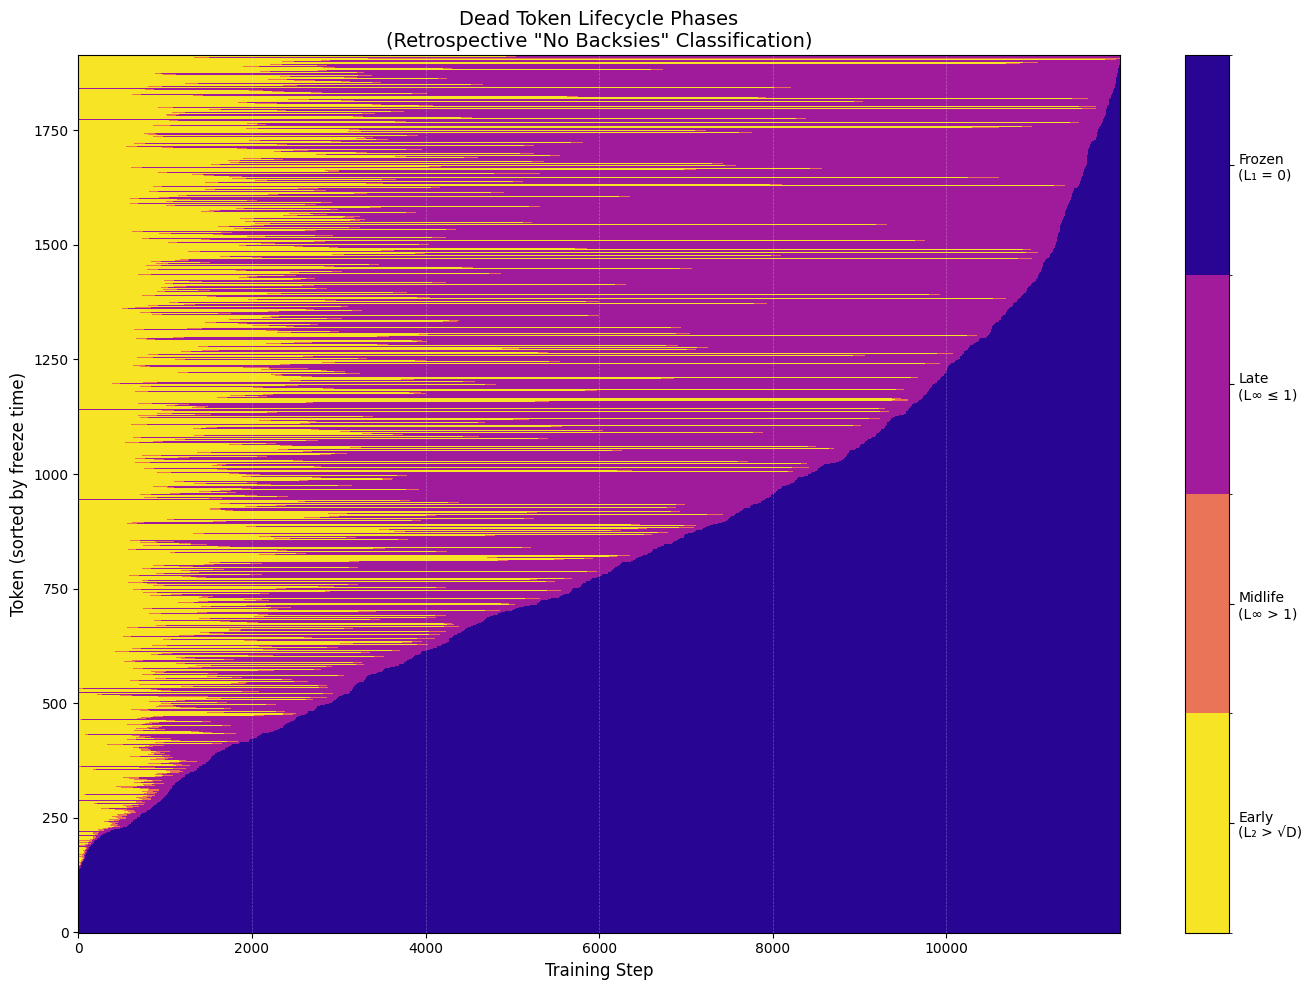

✓ Saved: lifecycle_stratigraphy@200.png, lifecycle_stratigraphy@72.png


In [10]:
# Create the stratigraphic plot
fig, ax = plt.subplots(figsize=(14, 10))

# Use plasma colormap with 4 discrete levels
cmap = plt.cm.plasma
colors = [cmap(0.95), cmap(0.65), cmap(0.35), cmap(0.05)]  # Yellow → Orange → Magenta → Violet
discrete_cmap = ListedColormap(colors)
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = BoundaryNorm(bounds, discrete_cmap.N)

# Plot
im = ax.imshow(
    phases_sorted.T,  # Transpose: tokens on y, steps on x
    aspect='auto',
    cmap=discrete_cmap,
    norm=norm,
    interpolation='nearest',
    origin='lower'
)

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('Token (sorted by freeze time)', fontsize=12)
ax.set_title('Dead Token Lifecycle Phases\n(Retrospective "No Backsies" Classification)', fontsize=14)

# Colorbar
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2, 3])
cbar.ax.set_yticklabels(['Early\n(L₂ > √D)', 'Midlife\n(L∞ > 1)', 'Late\n(L∞ ≤ 1)', 'Frozen\n(L₁ = 0)'])
cbar.ax.tick_params(labelsize=10)

# Add step markers
for step in [2000, 4000, 6000, 8000, 10000]:
    if step < TRAINING_STEPS:
        ax.axvline(step, color='white', alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('lifecycle_stratigraphy@200.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.savefig('lifecycle_stratigraphy@72.png', dpi=72, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Saved: lifecycle_stratigraphy@200.png, lifecycle_stratigraphy@72.png")

## Phase Population Over Time

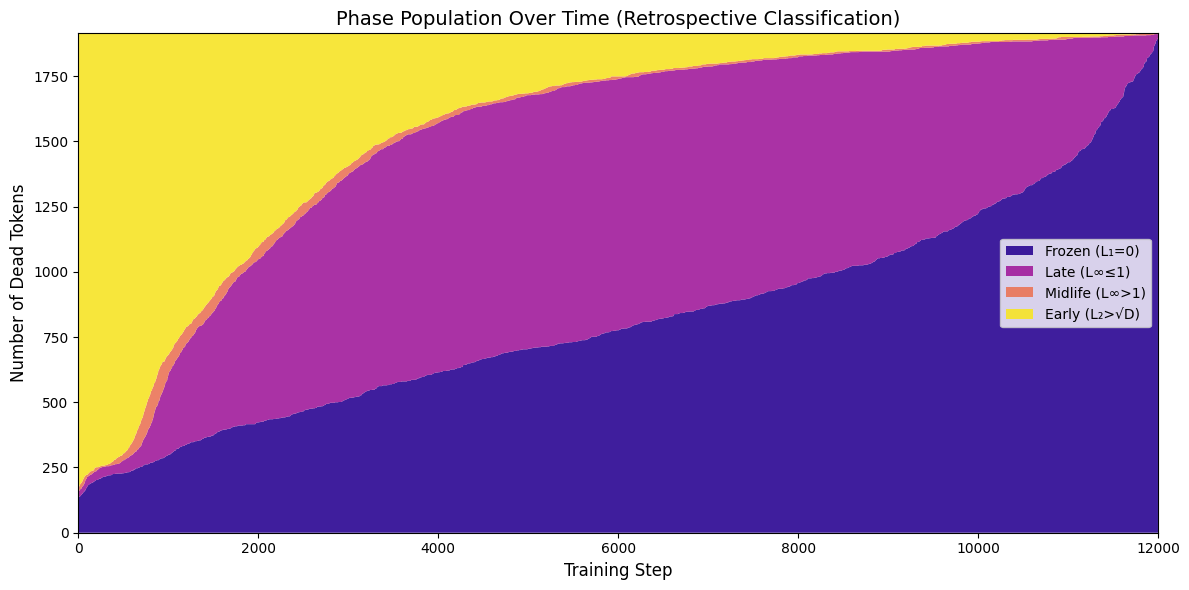

✓ Saved: phase_population@200.png, phase_population@72.png


In [11]:
# Count tokens in each phase at each step
phase_counts = np.zeros((TRAINING_STEPS, 4))
for phase in range(4):
    phase_counts[:, phase] = (phases == phase).sum(axis=1)

fig, ax = plt.subplots(figsize=(12, 6))

ax.stackplot(
    range(TRAINING_STEPS),
    phase_counts[:, 3],  # Frozen (bottom)
    phase_counts[:, 2],  # Late
    phase_counts[:, 1],  # Midlife
    phase_counts[:, 0],  # Early (top)
    labels=['Frozen (L₁=0)', 'Late (L∞≤1)', 'Midlife (L∞>1)', 'Early (L₂>√D)'],
    colors=[colors[3], colors[2], colors[1], colors[0]],
    alpha=0.9
)

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('Number of Dead Tokens', fontsize=12)
ax.set_title('Phase Population Over Time (Retrospective Classification)', fontsize=14)
ax.legend(loc='center right')
ax.set_xlim(0, TRAINING_STEPS)
ax.set_ylim(0, n_dead)

plt.tight_layout()
plt.savefig('phase_population@200.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.savefig('phase_population@72.png', dpi=72, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Saved: phase_population@200.png, phase_population@72.png")

## The Stragglers

Who didn't freeze? Let's look at the tokens that are still in Late phase at the end.

In [12]:
# Find tokens that didn't freeze
unfrozen_mask = final_phases != 3
unfrozen_indices = np.where(unfrozen_mask)[0]
unfrozen_ids = [dead_token_ids[i] for i in unfrozen_indices]

print(f"Tokens that didn't freeze: {len(unfrozen_ids)}")
print(f"\nPhase distribution of unfrozen tokens:")
for phase, name in enumerate(['Early', 'Midlife', 'Late']):
    count = (final_phases[unfrozen_mask] == phase).sum()
    if count > 0:
        print(f"  {name}: {count}")

# What are these tokens?
print(f"\nFirst 20 unfrozen token IDs and their decoded forms:")
for i, tok_id in enumerate(unfrozen_ids[:20]):
    try:
        decoded = tokenizer.decode([tok_id])
        decoded_repr = repr(decoded)
    except:
        decoded_repr = "<decode error>"
    phase = final_phases[unfrozen_indices[i]]
    phase_name = ['Early', 'Midlife', 'Late', 'Frozen'][phase]
    print(f"  {tok_id:5d}: {decoded_repr:30s} ({phase_name})")

Tokens that didn't freeze: 16

Phase distribution of unfrozen tokens:
  Midlife: 3
  Late: 13

First 20 unfrozen token IDs and their decoded forms:
   2376: 'กระ'                          (Midlife)
   2459: 'พนัน'                         (Late)
   2534: 'นิ'                           (Midlife)
   2549: 'ค์'                           (Late)
   2558: 'รุ'                           (Late)
   2626: 'เร'                           (Midlife)
   2726: 'สำคัญ'                        (Late)
   3309: 'บริหาร'                       (Late)
   3373: 'สบาย'                         (Late)
   3579: 'ร้อน'                         (Late)
   3601: 'รู้สึก'                       (Late)
   3691: 'ญี่ป'                         (Late)
   3697: 'วิชา'                         (Late)
   3788: 'กด'                           (Late)
   3864: 'ุตสาห'                        (Late)
   3914: 'จำนวนมาก'                     (Late)


## Save Data

In [13]:
# Save the trajectory data for further analysis
np.savez_compressed(
    'lifecycle_trajectories.npz',
    L1_history=L1_history,
    L2_history=L2_history,
    Linf_history=Linf_history,
    phases=phases,
    losses=losses,
    dead_token_ids=np.array(dead_token_ids),
    freeze_times=freeze_times
)

print("✓ Saved: lifecycle_trajectories.npz")
print(f"  Contains: L1/L2/Linf history, phases, losses, token IDs, freeze times")

✓ Saved: lifecycle_trajectories.npz
  Contains: L1/L2/Linf history, phases, losses, token IDs, freeze times
